# Neaural Network with PyTorch on CIFAR10

A grayscale image is an array of pixels. Each pixel is usually a value in a range of 0 to 255. An image with size 32×32 would have 1024 pixels. Taking it as input to a neural network would mean the first layer to have at least 1024 input weights.

Looking at the pixel value has little use to understanding the picture, because data is hiding in the spatial structure (e.g., whether there is a horizontal line or a vertical line on the picture). Hence the traditional neural network will find it difficult to find out information from image input.

We will find it to contain three types of layers:

1. Convolutional layers
2. Pooling layers
3. Fully-connected layers

The filter of a convolutional layer is to multiply with the input pixels, and then sum up the result. This result is one pixel value at the output. The filter will move around the input image to fill out all pixel values at the output. Usually multiple filters are applied to the same input, producing multiple output tensors. These output tensors are called the feature maps produced by this layer. They are stacked together as one tensor and pass on to the next layer as input.

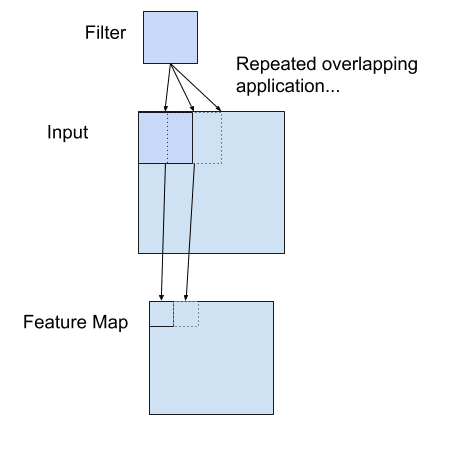

Pooling layer is to downsample the previous layer’s feature map. It is usually used after a convolutional layer to consolidate features learned. It can compress and generalize the feature representations. A pooling layer also has a receptive field and usually it is to take the average (average pooling) or the maximum (max pooling) over all values on the receptive field.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x

model = CIFAR10Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

n_epochs = 20
for epoch in range(n_epochs):
    for inputs, labels in trainloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = 0
    count = 0
    for inputs, labels in testloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

torch.save(model.state_dict(), "cifar10model.pth")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 0: model accuracy 36.01%
Epoch 1: model accuracy 40.78%
Epoch 2: model accuracy 45.32%
Epoch 3: model accuracy 48.24%
Epoch 4: model accuracy 50.52%
Epoch 5: model accuracy 53.52%
Epoch 6: model accuracy 55.64%
Epoch 7: model accuracy 58.33%
Epoch 8: model accuracy 59.98%
Epoch 9: model accuracy 61.69%
Epoch 10: model accuracy 63.65%
Epoch 11: model accuracy 65.33%
Epoch 12: model accuracy 66.22%
Epoch 13: model accuracy 68.25%
Epoch 14: model accuracy 68.72%
Epoch 15: model accuracy 70.30%
Epoch 16: model accuracy 72.64%
Epoch 17: model accuracy 73.56%
Epoch 18: model accuracy 74.36%
Epoch 19: model accuracy 76.38%


The CIFAR-10 dataset provides images in 32×32 pixels in RGB color (i.e., 3 color channels). There are 10 classes, labelled in integers 0 to 9. Whenever we are working on PyTorch neural network models for images, we will find the sister library torchvision useful. In the above, we used it to download the CIFAR-10 dataset from the Internet and transform it into a PyTorch tensor:

In [2]:
...
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


we also used a DataLoader in PyTorch to help creating batches for training. Training is to optimize the cross entropy loss of the model, using stochastic gradient descent. It is a classification model, hence accuracy of classification is more intuitive than cross entropy, which is computed at the end of each epoch, by comparing the maximum value in the output logit to the dataset’s labels:

In [3]:
...
acc += (torch.argmax(y_pred, 1) == labels).float().sum()

It takes time to run the program above to train the network. This network should be able to achieve above 70% accuracy in classification.

It is typical in a network for image classification to be comprised of convolutional layers at an early stage, with dropout and pooling layers interleaved. Then, at a later stage, the output from convolutional layers is flattened and processed by some fully connected layers.

## What Are in Feature Maps?

There are two convolutional layers in the network defined above. They are both defined with kernel size of 3×3, hence it is looking at 9 pixels at a time to produce one output pixel. Note that the first convolutional layer is taking the RGB image as input. Hence each pixel has three channels. The second convolutional layer is taking a feature map with 32 channels as input. Each “pixel” as it sees will have 32 values. Thus the second convolutional layer has more parameters even they have the same receptive field.

Let’s see what is in the feature map. Let’s say we pick one input sample from the training set:

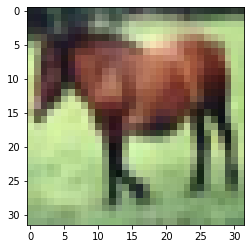

In [4]:
import matplotlib.pyplot as plt

plt.imshow(trainset.data[7])
plt.show()

First, we need to convert this into a PyTorch tensor and make it a batch of one image. PyTorch models expect each image as a tensor in the format of (channel, height, width) but the data we read is in the format of (height, width, channel). If we use torchvision to transform the image into PyTorch tensors, this format conversion is done automatically. Otherwise, we need to permute the dimensions before use.

Afterward, pass it on through the model’s first convolution layer and capture the output. we need to tell PyTorch that no gradient is needed for this calculation as we are not going to optimize the model weight:

In [5]:
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2)
model.eval()
with torch.no_grad():
    feature_maps = model.conv1(X)

<ipython-input-5-f3dd183cadd6>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2)


The feature maps are in one tensor. You can visualize them using matplotlib:

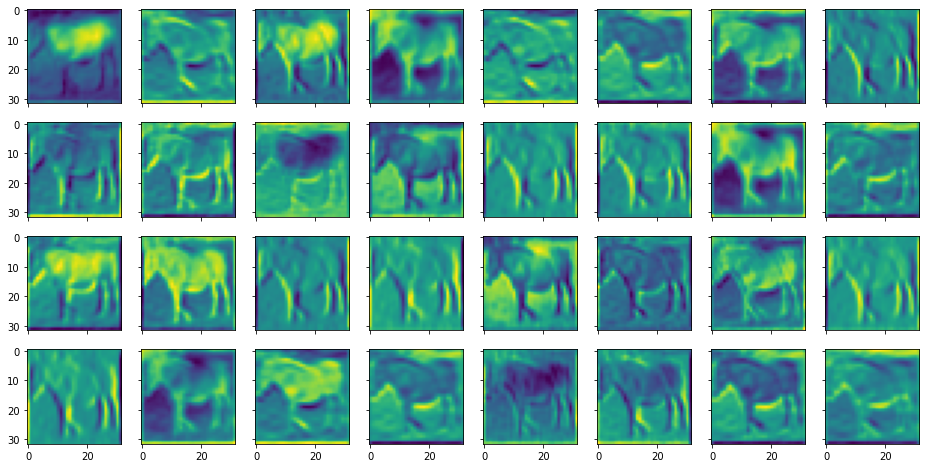

In [6]:
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[0][i])
plt.show()

we can see that they are called feature maps because they are highlighting certain features from the input image. A feature is identified using a small window (in this case, over a 3×3 pixels filter). The input image has three color channels. Each channel has a different filter applied, and their results are combined for an output feature.

we can similarly display the feature map from the output of the second convolutional layer as follows:

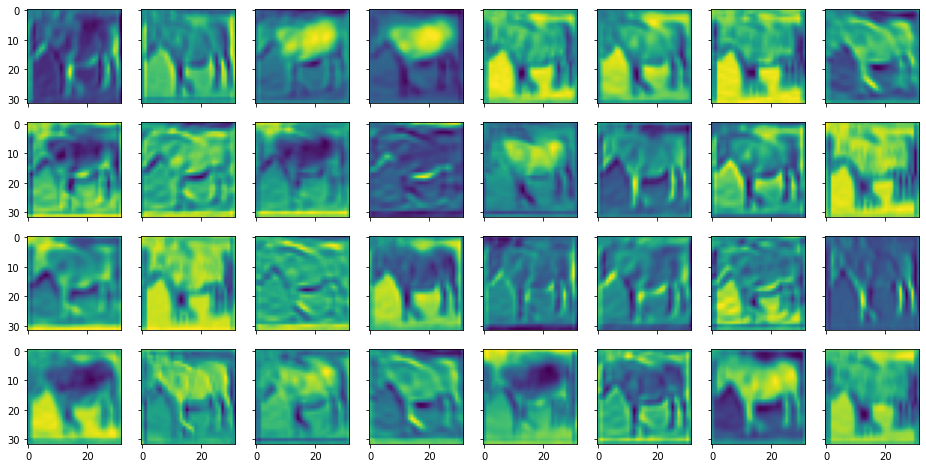

In [7]:
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2)

model.eval()
with torch.no_grad():
    feature_maps = model.act1(model.conv1(X))
    feature_maps = model.drop1(feature_maps)
    feature_maps = model.conv2(feature_maps)

fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[0][i])
plt.show()

Compared to the output of the first convolutional layer, the feature maps from the second convolutional layer looks blurry and more abstract. But these are more useful for the model to identify the objects.

Putting everything together, the code below loads the saved model from the previous section and generate the feature maps:

Files already downloaded and verified


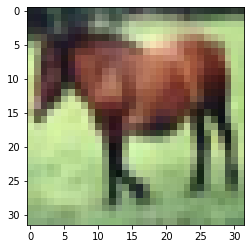

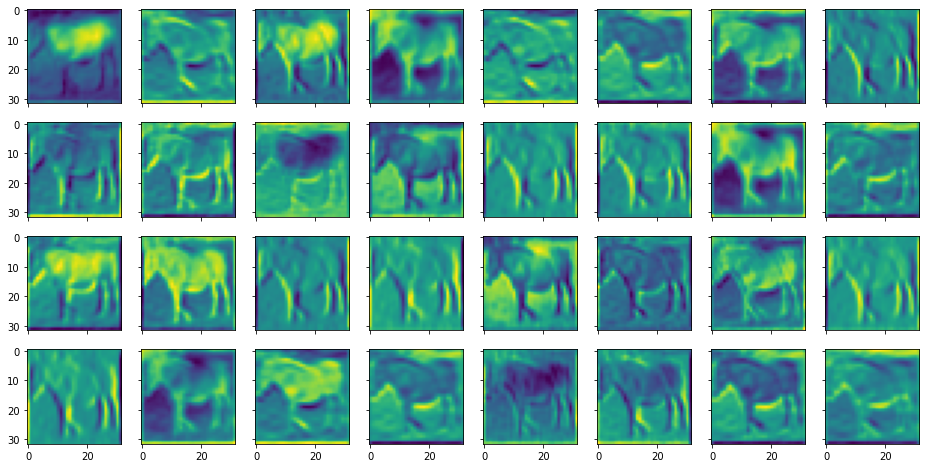

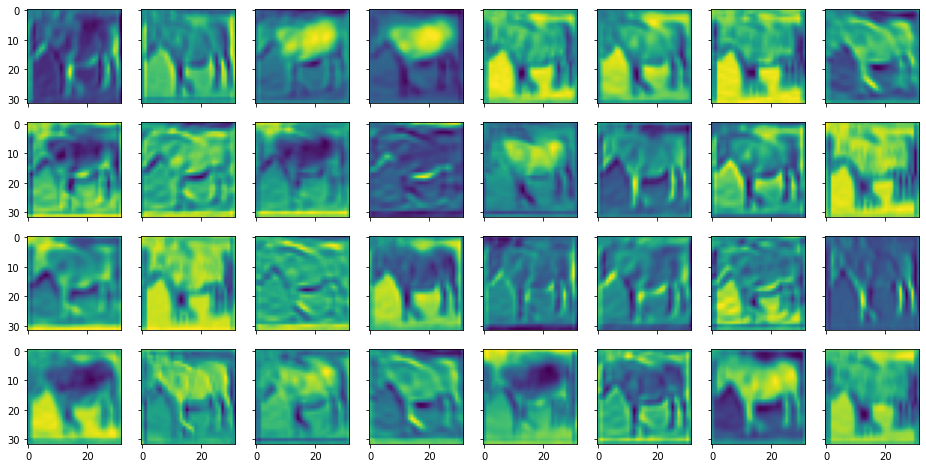

In [8]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(512, 10)

    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x

model = CIFAR10Model()
model.load_state_dict(torch.load("cifar10model.pth"))

plt.imshow(trainset.data[7])
plt.show()

X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2)
model.eval()
with torch.no_grad():
    feature_maps = model.conv1(X)
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[0][i])
plt.show()

with torch.no_grad():
    feature_maps = model.act1(model.conv1(X))
    feature_maps = model.drop1(feature_maps)
    feature_maps = model.conv2(feature_maps)
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[0][i])
plt.show()